Code ran under dev branch of Pyro and master branch of Pytorch  
Pytorch: 79245306c7fefae7b16633985572caf816e0b380    
Pyro: c99a9e73b4ba406b8f20a1f0c0c2166e65ee7f40  

### Personal observation:
I think the pyro API is relatively easy to understand, and the devs team make an effort to separete the model and the inference.   
As using sampling to do inference goes, a sampler (called kernel) takes a model and internally setup the logp and dlogp, as well as the MH kernel for proposal.   
One awkward thing of pyro is that, when a distribution is wrapped into a torch Variable using `pyro.sample`, it's default value is taken from the memory instead of the default of the distribution. It cause slow convergence a lot of times.  
To make the comparison more direct, all optimuization and tuning in pymc3 is turned off.  

In [1]:
%pylab inline
from tqdm import tqdm, trange
from collections import defaultdict, namedtuple
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc.nuts import NUTS
from pyro.infer.mcmc.mcmc import MCMC

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pyro.__version__

'0.2.0+c99a9e7'

# High-D Gaussian

In [3]:
ndim, num_obs = 10, 100
nchain = 2
mu0 = np.arange(ndim)
data = np.random.randn(num_obs, ndim) + mu0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 1000/1000 [00:01<00:00, 529.23it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '25214' (I am process '25215')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '25214' (I am process '25216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '25215' (I am process '25216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_di

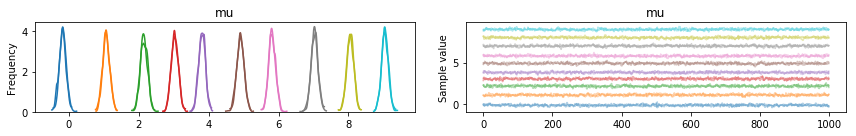

In [4]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10., shape=ndim)
    obs = pm.Normal('obs', mu, 1., observed=data)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

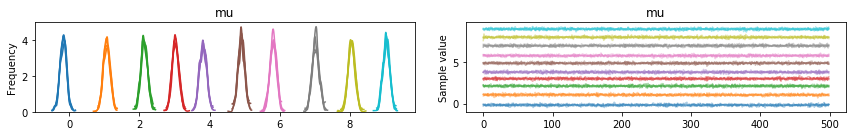

In [5]:
pm.traceplot(trace);

## In Pyro (HMC)

In [6]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu',
                     dist.Normal(
                         mu=Variable(torch.Tensor(torch.zeros(ndim))),
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10))
                                )
                     )
    pyro.sample('obs',
                dist.Normal(
                    mu=mu,
                    sigma=Variable(torch.Tensor(torch.ones(ndim)))
                           ),
                obs=data_)

In [7]:
draw = 2000
ntune = 1000
n_steps = max(1, int(step.path_length / step.step_size))
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)
mcmc_run = MCMC(hmc_kernel, num_samples=draw, warmup_steps=ntune)

mtrace = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace.append(np.asarray(post_pyro)[ntune:])

100%|█████████▉| 2000/2001 [00:20<00:00, 96.94it/s]


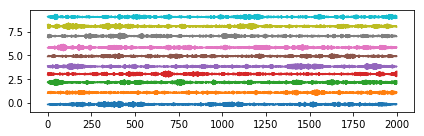

In [8]:
mtrace = np.asarray(mtrace).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace);
plt.tight_layout();

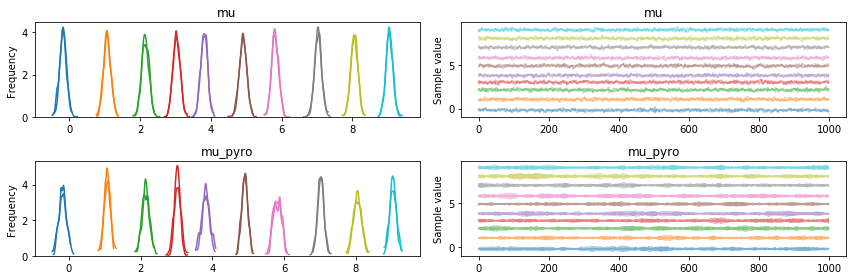

In [9]:
trace_hmc.add_values(dict(mu_pyro=mtrace))
pm.traceplot(trace_hmc);

## In Pyro (NUTS)

In [10]:
step.step_size

0.14058533129758727

In [11]:
draw = 1000
ntune = 500
nuts_kernel = NUTS(m2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, num_samples=draw, warmup_steps=ntune)

mtrace2 = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace2.append(np.asarray(post_pyro)[ntune:])

100%|█████████▉| 1000/1001 [00:04<00:00, 245.89it/s]


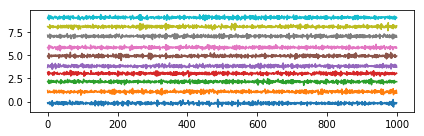

In [12]:
mtrace2 = np.asarray(mtrace2).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace2);
plt.tight_layout();

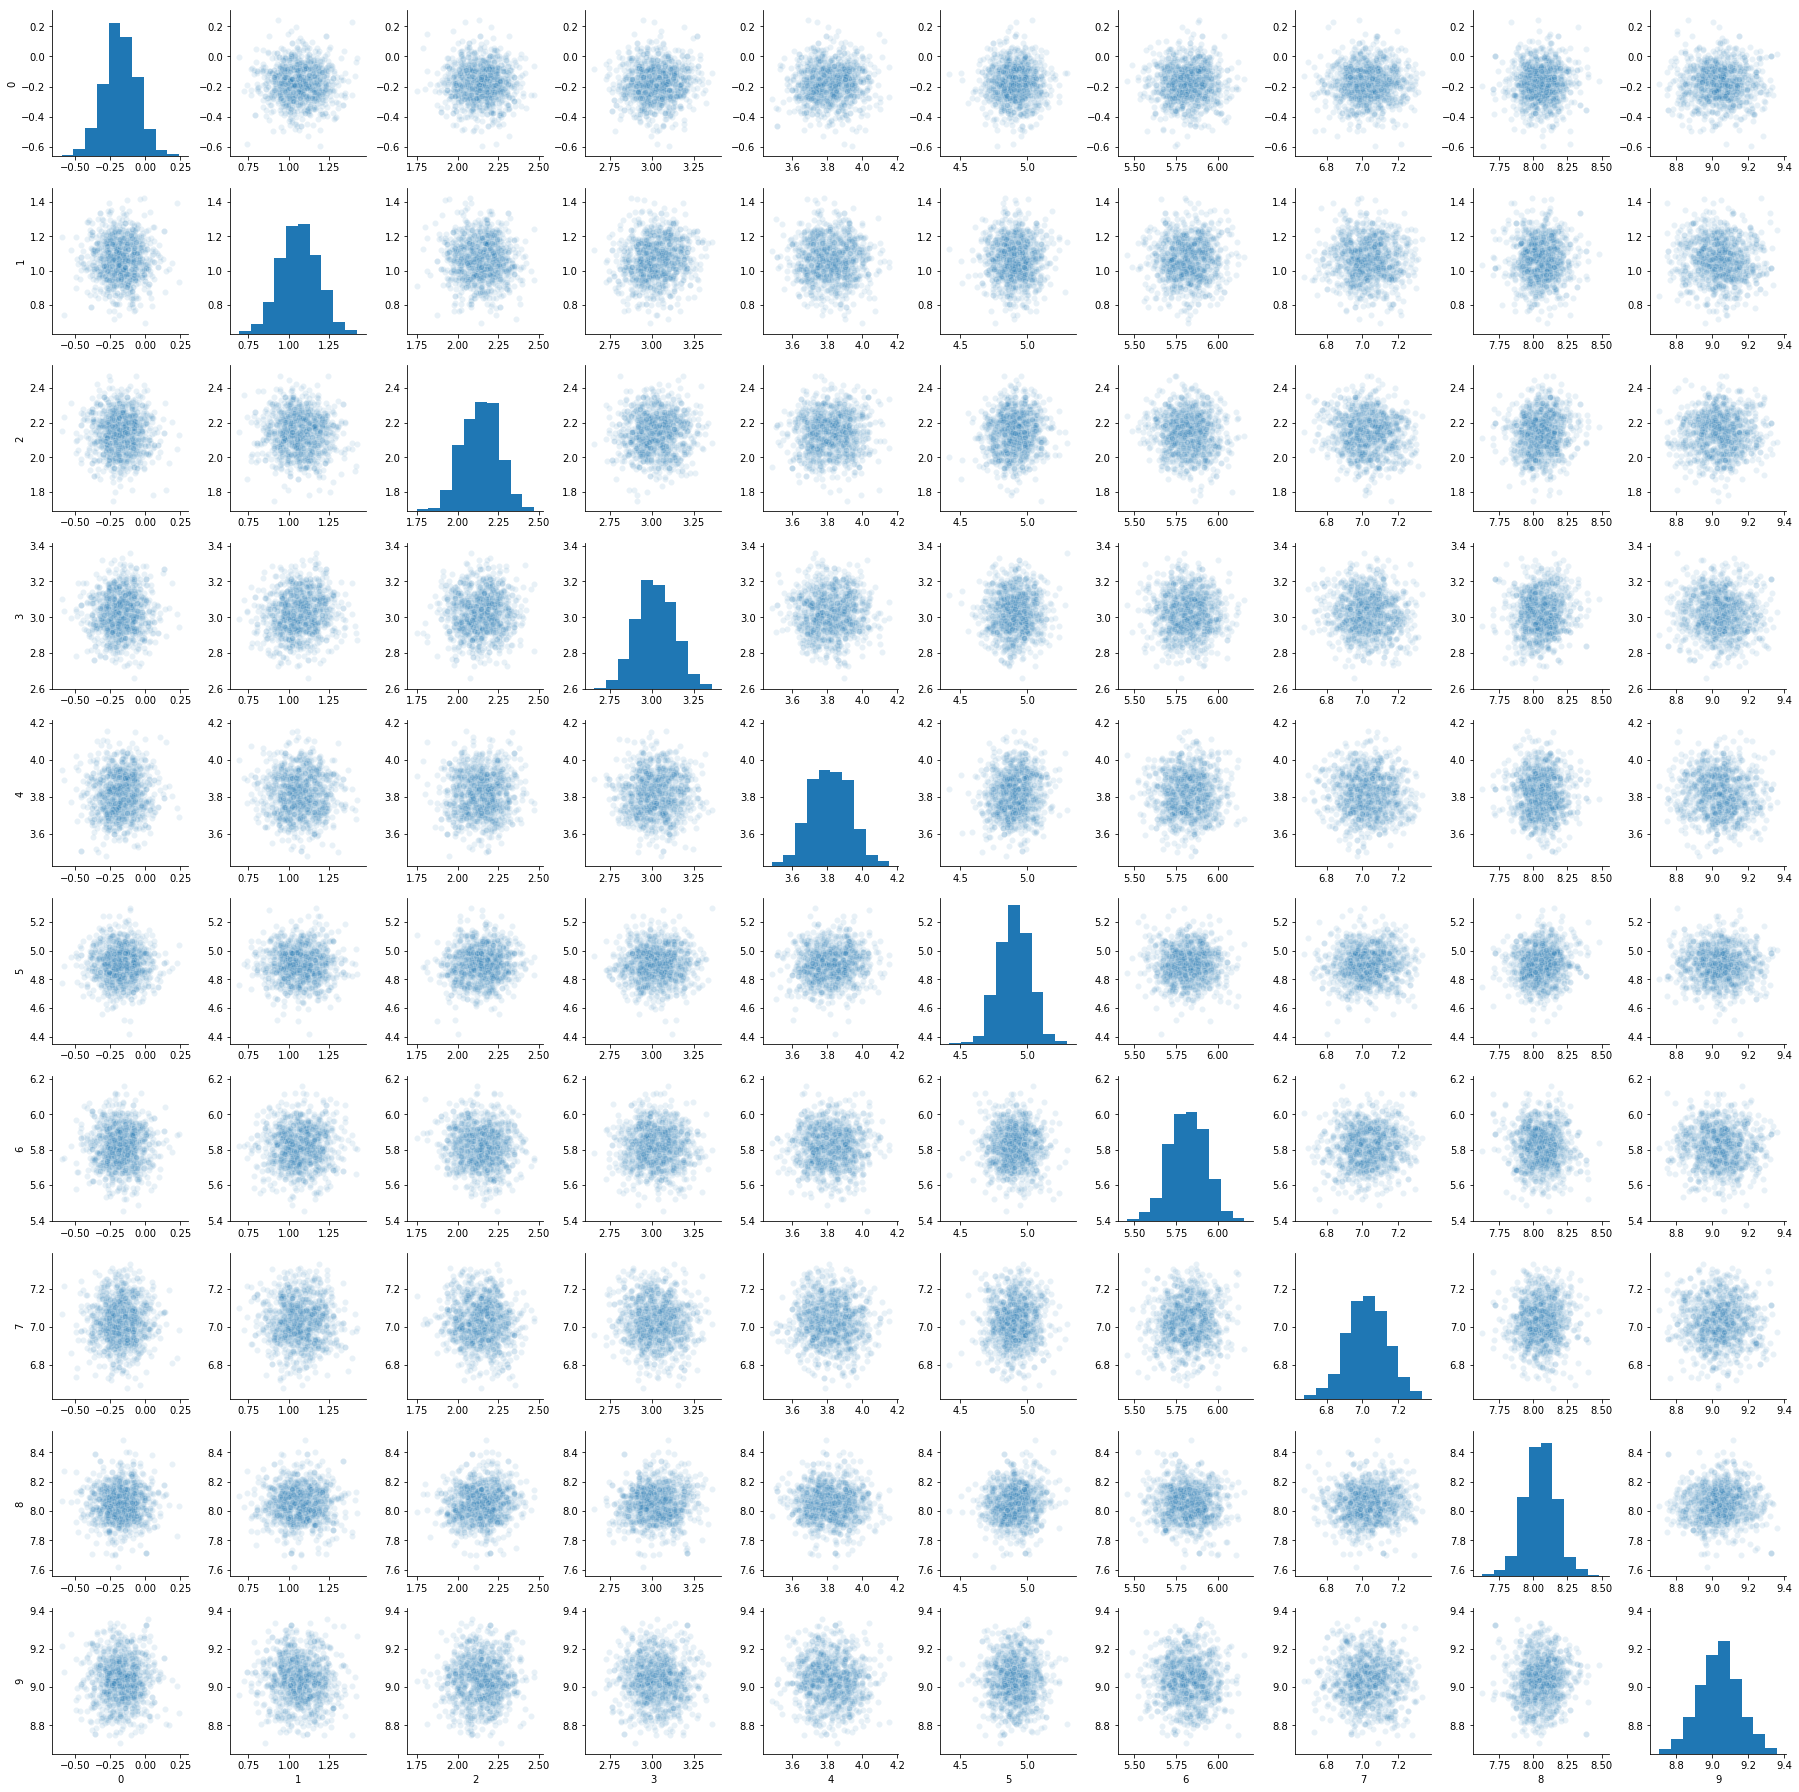

In [13]:
sns.pairplot(pd.DataFrame(mtrace2), plot_kws=dict(alpha=.1));

## Getting logp from pyro

In [14]:
def m2():
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu',
                     dist.Normal(
                         mu=Variable(torch.Tensor(torch.zeros(ndim))),
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10))
                                )
                     )
    pyro.sample('obs',
                dist.Normal(
                    mu=mu,
                    sigma=Variable(torch.Tensor(torch.ones(ndim)))
                           ),
                obs=data_)
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)

In [15]:
hmc_kernel.setup()

In [16]:
hmc_kernel.initial_trace()

In [17]:
trace = hmc_kernel._prototype_trace

In [18]:
z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
z

{'mu': tensor([ -5.3879,  20.8109, -10.4132,   5.9171,  15.9147,  -8.1217,
           4.0939,   1.4678,   2.4587,   8.9365])}

In [19]:
trace.log_prob_sum()

tensor(-49689.2461)

In [20]:
z['mu'].numpy()

array([ -5.3878903,  20.810902 , -10.413216 ,   5.917138 ,  15.914747 ,
        -8.121747 ,   4.093879 ,   1.4677603,   2.4586954,   8.936519 ],
      dtype=float32)

In [21]:
from scipy import stats as st
st.norm.logpdf(data, loc=z['mu'].numpy(), scale=1.).sum()

-49651.88441254971

In [22]:
st.norm.logpdf(data, loc=mu0, scale=1.).sum()

-1446.5421693214716

In [23]:
print(hmc_kernel._args, hmc_kernel._kwargs,'/t')

() {} /t


In [24]:
trace.nodes

NodeView(('_INPUT', 'mu', 'obs', '_RETURN'))

In [25]:
trace.nodes['mu']['value']

tensor([ -5.3879,  20.8109, -10.4132,   5.9171,  15.9147,  -8.1217,
          4.0939,   1.4678,   2.4587,   8.9365])

In [26]:
hmc_kernel._get_trace(z).log_prob_sum()

tensor(-49689.2461)

In [27]:
z_next = {key: Variable(torch.Tensor(mu0)) for key, val in z.items()}
z_next

{'mu': tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])}

In [28]:
hmc_kernel._get_trace(z_next).log_prob_sum()

tensor(-1480.1825)

# Chain of Gaussian
adapted from the test case
https://github.com/uber/pyro/blob/7b3a0a833b836c1b7b1e981091b514baec819c40/tests/infer/mcmc/test_hmc.py#L32-L37

Multiprocess sampling (2 chains in 4 jobs)
HamiltonianMC: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:01<00:00, 1842.18it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


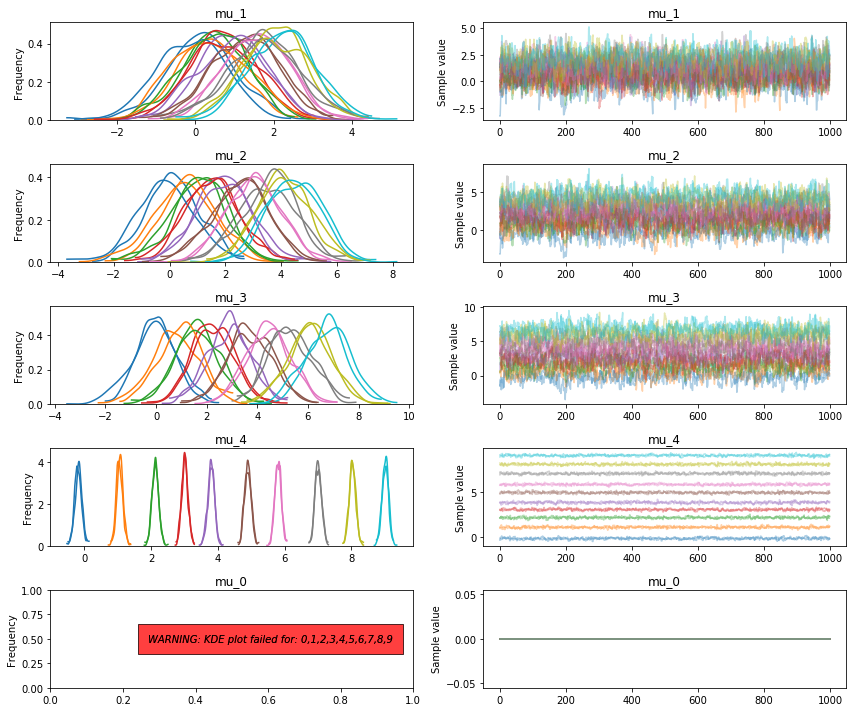

In [29]:
import theano.tensor as tt
import theano

ndim = 10
nlayer = 4
with pm.Model() as chain_gaussian:
    mu = pm.Deterministic('mu_0', tt.zeros(ndim))
    for i in range(nlayer):
        mu = pm.Normal('mu_{}'.format(i+1), mu=mu, sd=1., shape=ndim)
    obs = pm.Normal('obs', mu=mu, sd=1., observed=data)
    
    step = pm.HamiltonianMC(step_scale=.01)
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

In [30]:
import logging

logging.basicConfig(format='%(levelname)s %(message)s')
logger = logging.getLogger('pyro')
logger.setLevel(logging.INFO)

class GaussianChain(object):

    def __init__(self, dim, chain_len):
        self.dim = dim
        self.chain_len = chain_len
        self.mu_0 = Variable(torch.zeros_like(torch.Tensor(self.dim)), requires_grad=True)
        self.lambda_prec = Variable(torch.ones_like(torch.Tensor(self.dim)))

    def model(self, data):
        mu = pyro.param('mu_0', self.mu_0)
        lambda_prec = self.lambda_prec
        for i in range(1, self.chain_len + 1):
            mu = pyro.sample('mu_{}'.format(i),
                             dist.Normal(mu=mu, sigma=Variable(lambda_prec.data)))
        pyro.sample('obs', dist.Normal(mu, Variable(lambda_prec.data)), obs=data)


fixture = GaussianChain(dim=ndim, chain_len=nlayer)
num_samples=1000
warmup_steps=300
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(fixture.model, **hmc_params)
mcmc_run = MCMC(hmc_kernel, num_samples, warmup_steps)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

data_ = Variable(torch.Tensor(data))
for t, _ in mcmc_run._traces(data_):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 65 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.923077
INFO Iteration: 130 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.792308
INFO Iteration: 195 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.702564
INFO Iteration: 260 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.657692
INFO Iteration: 325 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.615385
INFO Iteration: 390 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.602564
INFO Iteration: 455 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.604396
INFO Iteration: 520 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.601923
INFO Iteration: 585 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.603419
INFO Iteration: 650 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.592308
INFO Iteration: 715 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.583217
INFO Iteration: 780 [SAMPLE]
INFO Step size: 0.165000 	 A

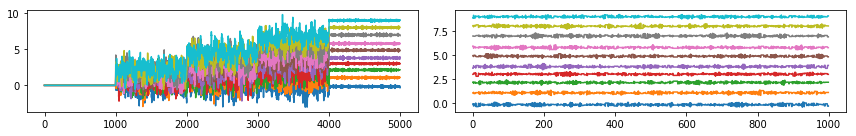

In [31]:
post_pyro = []
for i in range(nlayer + 1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000, :, np.newaxis])

post_pyro = np.asarray(post_pyro).reshape([(nlayer + 1) * 1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze())
ax[1].plot(post_pyro[4000:, :].squeeze())
plt.tight_layout()

In [32]:
def chain_gaussian2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.param('mu_0', Variable(torch.zeros(ndim), requires_grad=True))
    for i in range(nlayer):
        mu = pyro.sample('mu_{}'.format(i + 1),
                         dist.Normal(mu=mu, sigma=Variable(torch.ones(ndim))))
    pyro.sample(
        'obs', dist.Normal(mu=mu, sigma=Variable(torch.ones(ndim))), obs=data_)


draw = 2000
ntune = 1000
hmc_params = {'step_size': 0.165, 'num_steps': 5}

hmc_kernel = HMC(chain_gaussian2, **hmc_params)
mcmc_run = MCMC(hmc_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 150 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.786667
INFO Iteration: 300 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.666667
INFO Iteration: 450 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.615556
INFO Iteration: 600 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.591667
INFO Iteration: 750 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.577333
INFO Iteration: 900 [WARMUP]
INFO Step size: 0.165000 	 Acceptance rate: 0.563333
INFO Iteration: 1050 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.570476
INFO Iteration: 1200 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.558333
INFO Iteration: 1350 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.548889
INFO Iteration: 1500 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.550667
INFO Iteration: 1650 [SAMPLE]
INFO Step size: 0.165000 	 Acceptance rate: 0.549697
INFO Iteration: 1800 [SAMPLE]
INFO Step size: 0.165

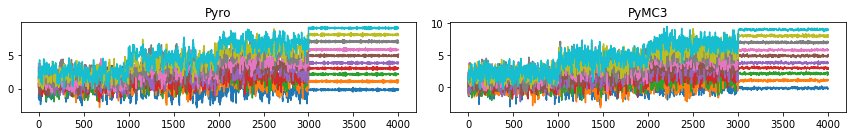

In [33]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer + 1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000, :, np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])

post_pyro = np.asarray(post_pyro).reshape([(nlayer) * 1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer) * 1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze())
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze())
ax[1].set_title('PyMC3')

plt.tight_layout()

In [34]:
draw = 2000
ntune = 1000
nuts_kernel = NUTS(chain_gaussian2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - NUTS ...
INFO Iteration: 150 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 300 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 450 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 600 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 750 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 900 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1050 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1200 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1350 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1500 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1650 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 1.000000
INFO Iteration: 1800 [SAMPLE]
INFO Step size: 0.10

In [35]:
with chain_gaussian:
    step = pm.NUTS()
    trace_nuts = pm.sample(1000, tune=1000, chains=nchain)

Auto-assigning NUTS sampler...
INFO Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_4, mu_3, mu_2, mu_1]
INFO NUTS: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:04<00:00, 454.74it/s]


In [36]:
nuts_kernel.step_size

0.1

In [37]:
step.step_size

0.09940884109588133

In [38]:
nuts_kernel.trajectory_length

6.283185307179586

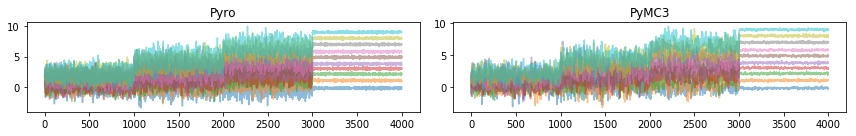

In [39]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])
    
post_pyro = np.asarray(post_pyro).reshape([(nlayer)*1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze(), alpha=.5);
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze(), alpha=.5)
ax[1].set_title('PyMC3')

plt.tight_layout();

# Gaussian with sigma

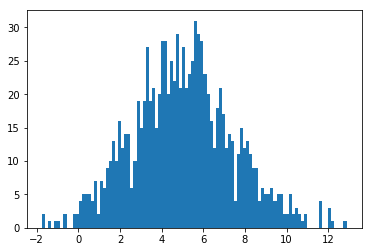

In [62]:
mu0, sigma = 5., 2.4
N = 1000
X = mu0 + np.random.randn(N, 1)*sigma

plt.hist(X, 100);

Multiprocess sampling (4 chains in 4 jobs)
INFO Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu]
INFO NUTS: [sd_log__, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1687.03it/s]


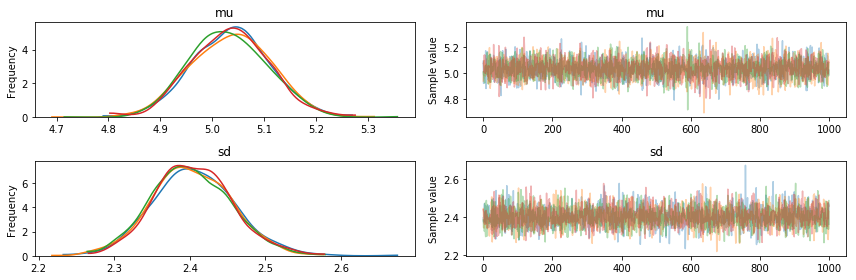

In [63]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=X)
    step = pm.NUTS()
    trace_pymc = pm.sample(1000, tune=1000, step=step)

pm.traceplot(trace_pymc);

In [64]:
ndim2 = 1
def m2():
    data_ = Variable(torch.Tensor(X))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(ndim2))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim2)*100.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(ndim2))),
                     Variable(torch.Tensor(torch.ones(ndim2))))
                    )
    pyro.sample('obs', dist.Normal(mu=mu, sigma=sd),
                obs=data_)

In [65]:
nuts_kernel = NUTS(m2)

In [66]:
nuts_kernel._reset()

In [67]:
nuts_kernel.setup()

In [68]:
trace = nuts_kernel.initial_trace()

In [69]:
trace.nodes['mu']

{'args': (),
 'cond_indep_stack': (),
 'continuation': None,
 'done': True,
 'fn': Normal(),
 'infer': {},
 'is_observed': False,
 'kwargs': {},
 'log_prob_sum': tensor(-5.7185),
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': tensor([-62.3479])}

In [70]:
zorg = dict(mu=mu0, sd=sigma)
z_next = {key: Variable(torch.Tensor(torch.ones(ndim2)*zorg[key])) for key in zorg.keys()}
z_next

{'mu': tensor([ 5.]), 'sd': tensor([ 2.4000])}

In [71]:
trace = nuts_kernel._get_trace(z_next)

In [72]:
# from pyro.ops.integrator import velocity_verlet

# z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
# r = {name: pyro.sample('r_{}_t={}'.format(name, hmc_kernel._t), hmc_kernel._r_dist[name]) for name in z}
# z_new, r_new = velocity_verlet(z, r, hmc_kernel._potential_energy, hmc_kernel.step_size, hmc_kernel.num_steps)

In [73]:
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc_run.kernel.setup()
mcmc_run.kernel._prototype_trace.nodes['mu']

{'args': (),
 'cond_indep_stack': (),
 'continuation': None,
 'done': True,
 'fn': Normal(),
 'infer': {},
 'is_observed': False,
 'kwargs': {},
 'log_prob_sum': tensor(-5.5468),
 'name': 'mu',
 'scale': 1.0,
 'stop': False,
 'type': 'sample',
 'value': tensor([-21.2909])}

In [74]:
mcmc_run.kernel._prototype_trace.nodes['sd']['value']

tensor([ 0.5013])

In [83]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(ndim2))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim2)*100.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(ndim2))),
                     Variable(torch.Tensor(torch.ones(ndim2))))
                    )
    pyro.sample('obs', dist.Normal(mu=mu, sigma=sd),
                obs=data_)

draw = 2000
ntune = 1000
nuts_kernel = NUTS(m2, step_size=.1)
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(X):
    post_trace['mu'].append(t.nodes['mu']['value'])
    post_trace['sd'].append(t.nodes['sd']['value'])

INFO Starting MCMC using kernel - NUTS ...
/usr/local/lib/python3.5/dist-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'sd'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))
INFO Iteration: 150 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 300 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 450 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 600 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 750 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 900 [WARMUP]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 1050 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 1200 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration: 1350 [SAMPLE]
INFO Step size: 0.100000 	 Acceptance rate: 0.000000
INFO Iteration:

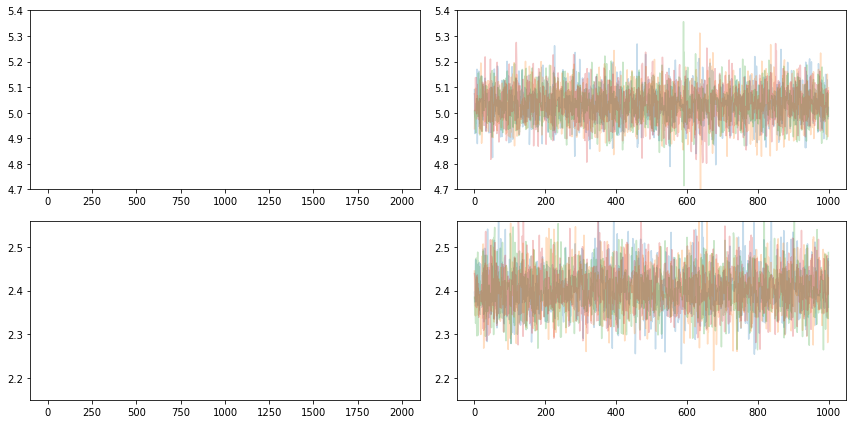

In [84]:
mupost_ = torch.stack(post_trace['mu'])
mupost = mupost_.data.numpy()
sdpost_ = torch.stack(post_trace['sd'])
sdpost = sdpost_.data.numpy()

_, axes = plt.subplots(2, 2, figsize=(12, 6))
ax=axes.flatten()
ax[0].plot(mupost)
ax[0].set_ylim([4.7, 5.4])
ax[1].plot(np.asarray(trace_pymc.get_values('mu', combine=False)).T, alpha=.25)
ax[1].set_ylim([4.7, 5.4])
ax[2].plot(sdpost)
ax[2].set_ylim([2.15, 2.56])
ax[3].plot(np.asarray(trace_pymc.get_values('sd', combine=False)).T, alpha=.25)
ax[3].set_ylim([2.15, 2.56])
plt.tight_layout();

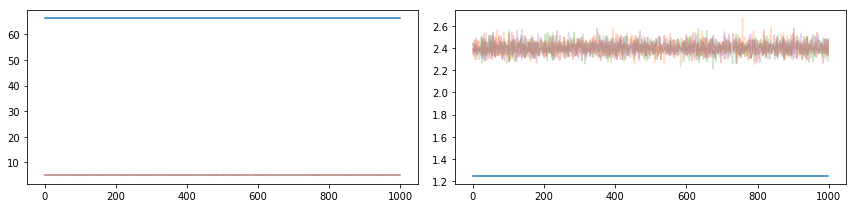

In [85]:
burnin = 1000

_, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(mupost[burnin:])
ax[0].plot(np.asarray(trace_pymc.get_values('mu', combine=False)).T, alpha=.25)
ax[1].plot(sdpost[burnin:])
ax[1].plot(np.asarray(trace_pymc.get_values('sd', combine=False)).T, alpha=.25)
plt.tight_layout();

# Regression

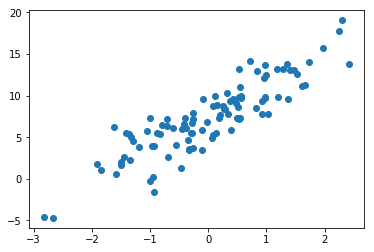

In [56]:
beta = [7., 3.4]
sigma = 2.1
N = 100
X = np.random.randn(N, 1)
Y = beta[0] + beta[1]*X + np.random.randn(N, 1)*sigma

plt.plot(X, Y, 'o');

Multiprocess sampling (4 chains in 4 jobs)
INFO Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, b, mu]
INFO NUTS: [sd_log__, b, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1462.39it/s]


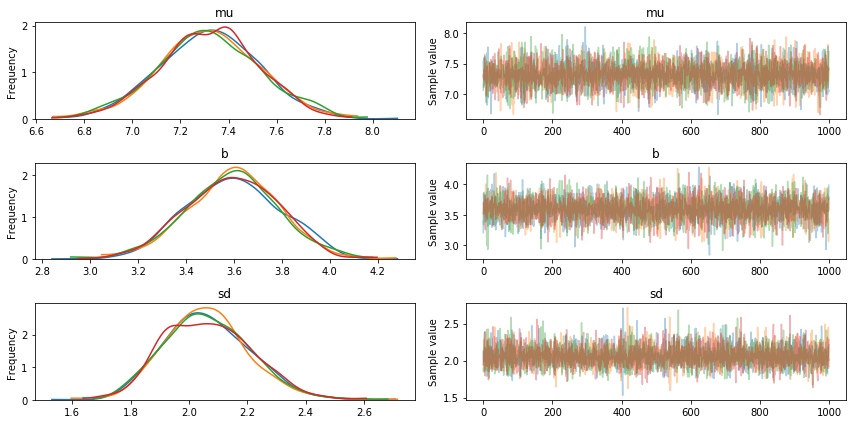

In [57]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    b = pm.Normal('b', 0., 10.)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('obs', mu=mu+X*b, sd=sd, observed=Y)
    step = pm.NUTS()
    trace_pymc = pm.sample(1000, tune=1000, step=step)

pm.traceplot(trace_pymc);

In [58]:
def m_regress(X, Y):
    X_, Y_ = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    mu = pyro.sample('mu', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(1))),
                     sigma=Variable(torch.Tensor(torch.ones(1)*100.)))
                    )
    b = pyro.sample('b', 
                     dist.Normal(
                     mu=Variable(torch.Tensor(torch.zeros(1))),
                     sigma=Variable(torch.Tensor(torch.ones(1)*10.)))
                    )
    sd = pyro.sample('sd', dist.Gamma(
                     Variable(torch.Tensor(torch.ones(1))),
                     Variable(torch.Tensor(torch.ones(1))))
                    )
    yhat = mu + X_ * b
    pyro.sample('obs', dist.Normal(mu=yhat, sigma=sd),
                obs=Y_)

draw = 2000
ntune = 1000
nuts_kernel = NUTS(m_regress, step_size=1.5)

In [59]:
mcmc_run = MCMC(nuts_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(X, Y):
    post_trace['mu'].append(t.nodes['mu']['value'])
    post_trace['b'].append(t.nodes['b']['value'])
    post_trace['sd'].append(t.nodes['sd']['value'])

INFO Starting MCMC using kernel - NUTS ...
/usr/local/lib/python3.5/dist-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'sd'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))
INFO Iteration: 150 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 300 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 450 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 600 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 750 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 900 [WARMUP]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 1050 [SAMPLE]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 1200 [SAMPLE]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration: 1350 [SAMPLE]
INFO Step size: 1.500000 	 Acceptance rate: 0.000000
INFO Iteration:

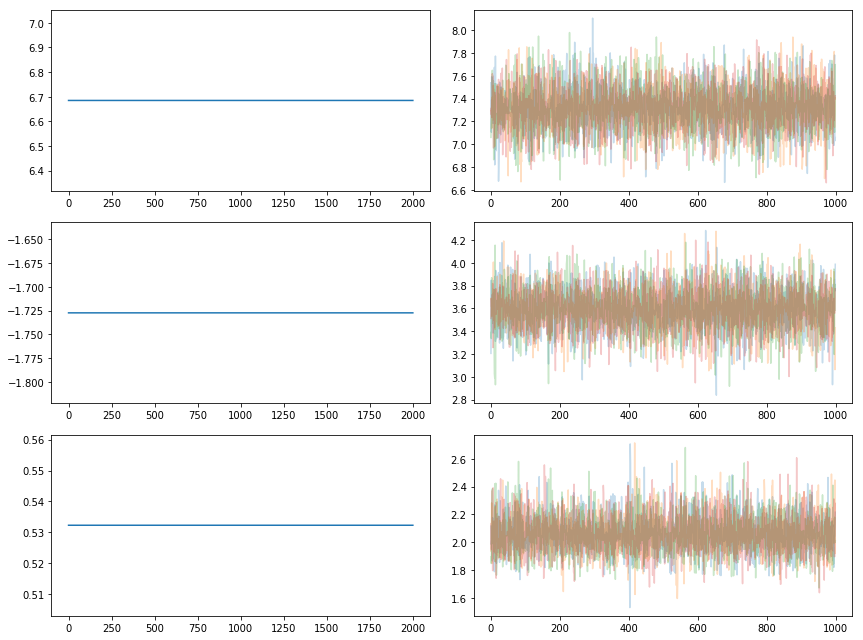

In [60]:
_, axes = plt.subplots(3, 2, figsize=(12, 9))

trace_pyro = defaultdict(list)
for i, varname in enumerate(['mu', 'b', 'sd']):
    post_tmp = torch.stack(post_trace[varname])
    post_ = post_tmp.data.numpy()
    trace_pyro[varname] = post_

    axes[i, 0].plot(post_)
    axes[i, 1].plot(np.asarray(trace_pymc.get_values(varname, combine=False)).T, alpha=.25)

plt.tight_layout();

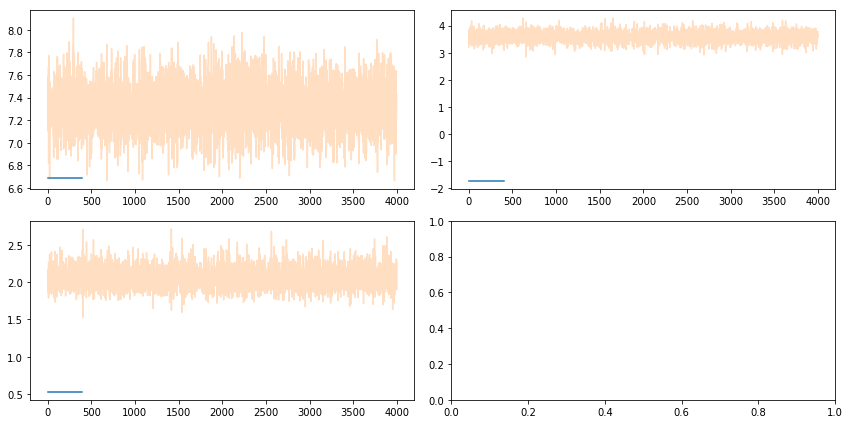

In [61]:
_, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

burnin=1600
for i, varname in enumerate(['mu', 'b', 'sd']):
    post_tmp = torch.stack(post_trace[varname])
    post_ = post_tmp.data.numpy()
    trace_pyro[varname] = post_

    axes[i].plot(trace_pyro[varname][burnin:])
    axes[i].plot(np.asarray(trace_pymc.get_values(varname, combine=True)).T, alpha=.25)

plt.tight_layout();